# FAKE NEWS CORPUS
Frederik Bahrt - project group: 22 

I have in this project used the database dump provided by Rahul.

### Imports
Let's start by doing the usual imports...

In [48]:
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
%matplotlib inline

### Establish database connection
The database is running in a docker container locally - let's connect!

In [49]:
conn = psycopg2.connect(user = "admin",
                        password = "admin",
                        host = "localhost",
                        port = "5432",
                        database = "fakenews_1m")
cursor = conn.cursor()

I can show that I have a working database containing 1000000 rows.

In [50]:
cursor.execute("SELECT count(*) FROM article")
count = cursor.fetchone()[0]
print "Database contains {} scraped articles".format(count)

Database contains 1000000 scraped articles


I can even do some more advanced queries, like associating an article with a label.

In [51]:
query = """SELECT article.article_id, typ.type_name 
           FROM article 
           INNER JOIN typ ON article.type_id = typ.type_id"""
cursor.execute(query)
res = cursor.fetchmany(10)

In [52]:
print "{:10}\t {:12}".format("article_id", "type_name")
print "------------------------------"
for row in res:
    print "{:10}\t {:>12}".format(row[0], row[1])

article_id	 type_name   
------------------------------
         2	        rumor
         6	         hate
         7	         hate
         8	         hate
         9	         hate
        10	         hate
        11	   unreliable
        13	   unreliable
        14	   unreliable
        15	   unreliable


## Statistics
I will in this section look at some basic, yet interesting, statistics for the dataset.

### Label Distribution

In [53]:
query = """SELECT typ.type_name, count(article.type_id) 
           FROM article 
           INNER JOIN typ ON typ.type_id = article.type_id 
           GROUP BY typ.type_name"""
cursor.execute(query)
res = cursor.fetchall()

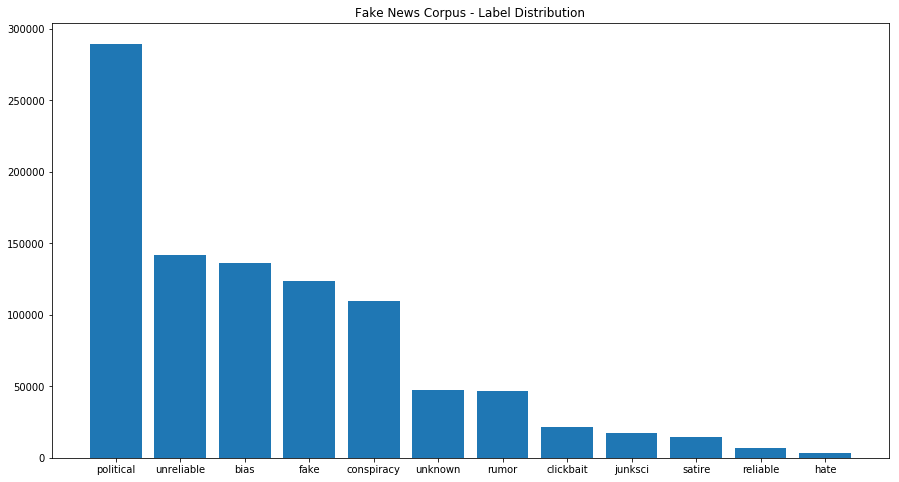

In [54]:
# Time to plot
res = sorted(res, key=lambda x: -x[1])

xs = np.arange(len(res))
ys = [int(t[1]) for t in res]
names = [t[0] for t in res]

fig, ax = plt.subplots(figsize=(15, 8))
plt.bar(xs, ys)
plt.xticks(xs, names)
plt.title("Fake News Corpus - Label Distribution")
plt.show()

### Who's contributing to fake news

#### Webpages contributing to fake news

In [55]:
query = """SELECT WP.domain_url, COUNT(WP.domain_url) 
           FROM (SELECT A.article_id, D.domain_url 
                 FROM article as A, webpage as W, domain as D 
                 WHERE A.article_id = W.article_id 
                      AND W.domain_id = D.domain_id                                                                    
                      AND A.type_id = 6) as WP 
           GROUP BY WP.domain_url 
           ORDER BY COUNT(WP.domain_url) DESC"""
cursor.execute(query)
res = cursor.fetchmany(20)

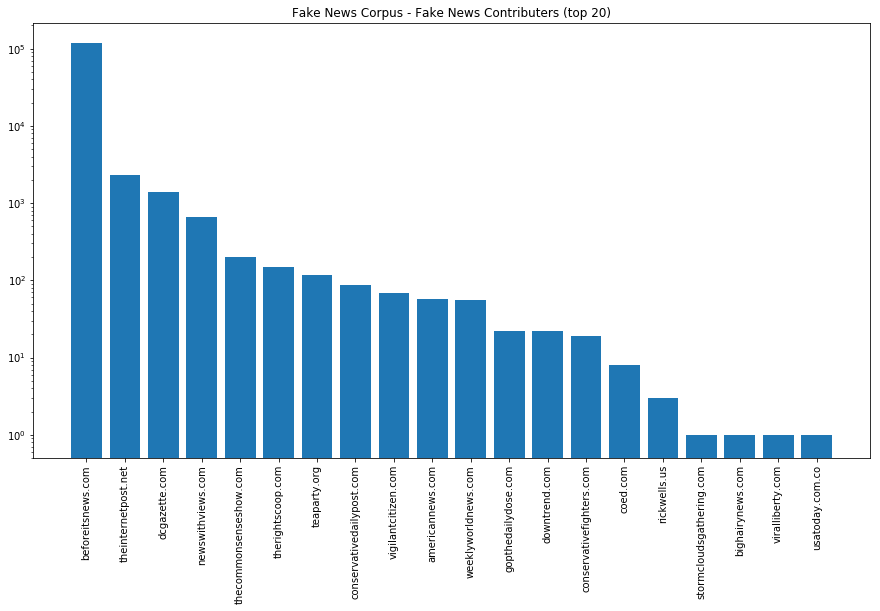

In [56]:
xs = np.arange(len(res))
ys = [int(t[1]) for t in res]
names = [t[0] for t in res]

fig, ax = plt.subplots(figsize=(15, 8))
ax.set_yscale('log')
plt.bar(xs, ys)
plt.xticks(xs, names, rotation='vertical')
plt.title("Fake News Corpus - Fake News Contributers (top 20)")
plt.show()

In [57]:
print "{} contributes to {} fake news articles.".format(names[0], ys[0])

beforeitsnews.com contributes to 118781 fake news articles.


The distribution shown above, is again, skewed - notice the logarithmic scaled y axis.

Let's do NER on the articles from beforeitnews.com to perhaps get some insight into the motivation behind the fake news articles.

First we need to select the article from beforeitnews.com (Let's query all, not just fake news)

In [58]:
query = """
    SELECT A.content
    FROM article as A, webpage as W, domain as D
    WHERE A.article_id = W.article_id 
        AND W.domain_id = D.domain_id
        AND D.domain_url = '{}' """.format(names[0])
cursor.execute(query)
res = cursor.fetchmany(10000) # computational expensive procedure below

In [59]:
import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")

text = res

def process_doc(text):
    doc = nlp(unicode(text[0]))
    # set - dont spam plz
    items = set([x.text.lower() for x in doc.ents if x.label_ == "ORG" or x.label_ == "PERSON"])
    return items

rez = []
for t in text:
    rez += process_doc(t) # Fucking concat ;--)
   
freq = dict(Counter(rez))

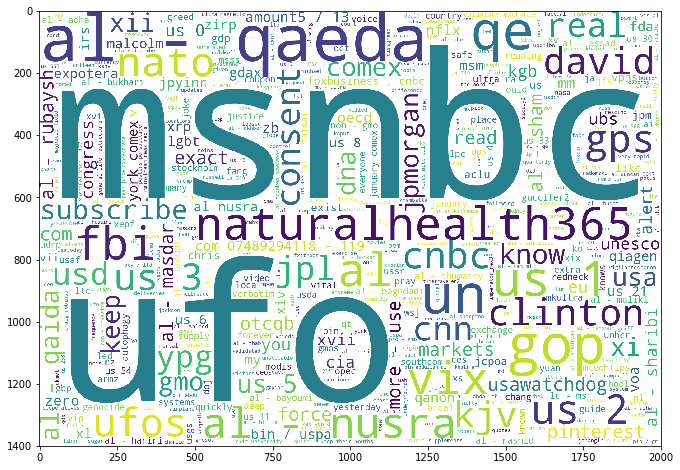

In [60]:
# Generate wordcloud
from wordcloud import WordCloud

wc = WordCloud(background_color="white",
               width=2000,
               height=1400, 
               max_words=500,
               relative_scaling=0.5,
               normalize_plurals=False).generate_from_frequencies(freq)

fig, ax = plt.subplots(figsize=(15, 8))
plt.imshow(wc)

By looking at the wordcloud above, there's word such as ufo, ufos, fbi & clinton. These word suggest that the website might be producing clickbait conspiracy news, which is most likely motivated by money.

## Politifact Scraping
I have scraped the sites
 - https://www.politifact.com/west-virginia/statements/
 - https://www.politifact.com/virginia/statements/
 
The websites, did not contain any articles, but short statements made by public figures.

My dataset contains the following attributes:
 - source: Entity which has made the claim
 - claim
 - verdict: Claim verdict
 - qoute: Small qoute associated with the verdict
 - date: Verdict date
 - scrape_date

In [61]:
import pandas as pd
df_pf = pd.read_csv("./scrape/PolitiFactScraper/virginia_west_virginia.csv")
df_pf.head()

,Unnamed: 0,source,claim,verdict,qoute,date,scrape_date
0,0,West Virginia Democratic Party,"The Affordable Care Act ""provided over 200,000...",true,It adds up,2019-04-17,2019-04-23 16:46:59.185497
1,0,Andrew Byrd,"""The states that have passed (campus carry law...",false,There's no common pattern,2019-04-16,2019-04-23 16:46:59.187476
2,0,Shelley Moore Capito,"""Beginning in the early 1990s, we built barrie...",barely-true,Overstates the case,2019-04-08,2019-04-23 16:46:59.189059
3,0,Mike Romano,"In the state rankings for ACT test scores, Wes...",barely-true,They clustered below AND above,2019-04-04,2019-04-23 16:46:59.190615
4,0,Mitch Carmichael,"In West Virginia, ""our students enter in at fo...",mostly-true,The general pattern holds,2019-04-03,2019-04-23 16:46:59.192111
